**Airbnb Success Predictor: Fractal Clustering Analysis (V2)**

Student Name: Ananya Praveen Shetty

Date: September 14, 2025

This notebook implements an iterative "Fractal Clustering" approach to identify the most strategic investment opportunities in the Los Angeles Airbnb market. We will start by clustering the entire dataset, identify a "golden cluster" based on performance, and then re-cluster that subset to zoom in on the highest-potential properties.

**Step 1: Setup and Data Loading**



In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

# Install gdown
!pip install -q gdown

# --- IMPORTANT ---
# Paste the FILE_ID from your Google Drive share link here
file_id = '1E__Uu-WG_aZHIfA7w74wJtnXO_sABMci'
output_filename = 'listings.csv'

# Download the file from Google Drive
!gdown --id {file_id} -O {output_filename}

# Now you can load the dataframe as before
import pandas as pd
df_full = pd.read_csv(output_filename)
df = pd.read_csv(output_filename)
print("Dataset downloaded and loaded successfully!")

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1E__Uu-WG_aZHIfA7w74wJtnXO_sABMci
To: /content/listings.csv
100% 9.65M/9.65M [00:00<00:00, 42.8MB/s]


/tmp/ipython-input-108376450.py:25: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.read_csv(output_filename)


Dataset downloaded and loaded successfully!


/tmp/ipython-input-108376450.py:26: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(output_filename)


**Step 2: Data Preparation**

In this step, we prepare our data for machine learning. We will select the four key features for clustering (latitude, longitude, price, review_scores_rating), clean the data by handling missing values and filtering extreme price outliers, and finally, scale the features using StandardScaler so they are all on a comparable scale

In [20]:
# Select the core features for our clustering model
features = ['latitude', 'longitude', 'price', 'review_scores_rating']
df_clean = df_full[features].copy()
df_clean.dropna(subset=['review_scores_rating'], inplace=True)

# Clean the 'price' column (it may be a string like '$1,200.00')
if df_clean['price'].dtype == 'object':
    df_clean['price'] = df_clean['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
else:
    df_clean['price'] = df_clean['price'].astype(float)

# Filter out extreme price outliers for more meaningful clusters
df_clean = df_clean[(df_clean['price'] > 0) & (df_clean['price'] < 800)]
print(f"Shape after cleaning and filtering: {df_clean.shape}")

# Scale the data using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean)
print("\nData preparation complete.")

Shape after cleaning and filtering: (27011, 4)

Data preparation complete.


<>:8: SyntaxWarning: invalid escape sequence '\$'
<>:8: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-1952206224.py:8: SyntaxWarning: invalid escape sequence '\$'
  df_clean['price'] = df_clean['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)


**Step 3: Define Objective Functions**

Here, we define two functions to help us quantitatively identify the "golden cluster" in each iteration. The **Profitability Score** rewards clusters that are both high-priced and highly-rated, while the **Quality Score** focuses purely on guest satisfaction.

In [21]:
def calculate_profitability_score(cluster_summary):
    """Calculates Profitability = avg_price * (avg_rating^2)"""
    return cluster_summary['avg_price'] * (cluster_summary['avg_rating'] ** 2)

def calculate_quality_score(cluster_summary):
    """Calculates Quality = avg_rating"""
    return cluster_summary['avg_rating']

print("Objective functions defined.")

Objective functions defined.


**Step 4: Fractal Clustering - Iteration 1**

We now perform the first round of clustering on the entire dataset. We will use K-Means, calculate the SSE and Silhouette Score, and then use our objective functions to analyze the resulting clusters and identify our first "golden cluster."

In [22]:
# --- Run K-Means ---
OPTIMAL_K = 5
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
labels_iter1 = kmeans.fit_predict(X_scaled)
df_clean['cluster_iter1'] = labels_iter1

# --- Compute SSE and Silhouette Score ---
sse_iter1 = kmeans.inertia_
silhouette_iter1 = silhouette_score(X_scaled, labels_iter1)
print("--- Iteration 1 Metrics ---")
print(f"Sum of Squared Errors (SSE): {sse_iter1:.2f}")
print(f"Silhouette Score: {silhouette_iter1:.4f}\n")

# --- Analyze Clusters with Objective Functions ---
summary_iter1 = df_clean.groupby('cluster_iter1').agg(
    avg_price=('price', 'mean'),
    avg_rating=('review_scores_rating', 'mean'),
    listing_count=('latitude', 'count')
)
summary_iter1['profitability_score'] = calculate_profitability_score(summary_iter1)
summary_iter1['quality_score'] = calculate_quality_score(summary_iter1)
print("--- Iteration 1 Cluster Analysis ---")
print(summary_iter1.sort_values(by='profitability_score', ascending=False))

# --- Identify the Golden Cluster ---
# We exclude the top cluster if it's a clear luxury outlier and pick the next best.
golden_cluster_id_1 = summary_iter1.sort_values(by='profitability_score', ascending=False).index[1]
golden_cluster_profitability_1 = summary_iter1.loc[golden_cluster_id_1]['profitability_score']
print(f"\nGolden Cluster from Iteration 1 is: Cluster {golden_cluster_id_1}")

--- Iteration 1 Metrics ---
Sum of Squared Errors (SSE): 48204.78
Silhouette Score: 0.2994

--- Iteration 1 Cluster Analysis ---
                avg_price  avg_rating  listing_count  profitability_score  \
cluster_iter1                                                               
2              464.863294    4.868931           3321         11020.276812   
3              167.379246    4.825817           3768          3898.013866   
0              148.759297    4.822140          13660          3459.104771   
4              127.839420    4.813718           5723          2962.280228   
1              144.781076    2.573043            539           958.530149   

               quality_score  
cluster_iter1                 
2                   4.868931  
3                   4.825817  
0                   4.822140  
4                   4.813718  
1                   2.573043  

Golden Cluster from Iteration 1 is: Cluster 3


**Step 5: EDAV on the Golden Cluster**

Now that we've identified our first golden cluster, we will perform a focused Exploratory Data Analysis on just the listings within this group. This helps us understand its specific characteristics, such as its geographic concentration and price distribution.

--- EDAV on Golden Cluster 3 ---
Number of listings: 3768


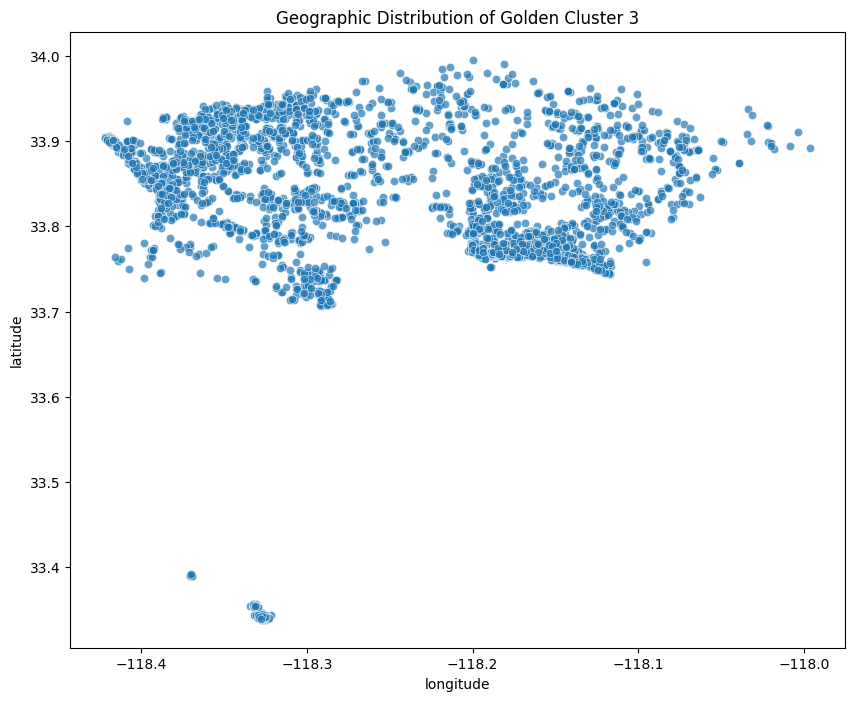

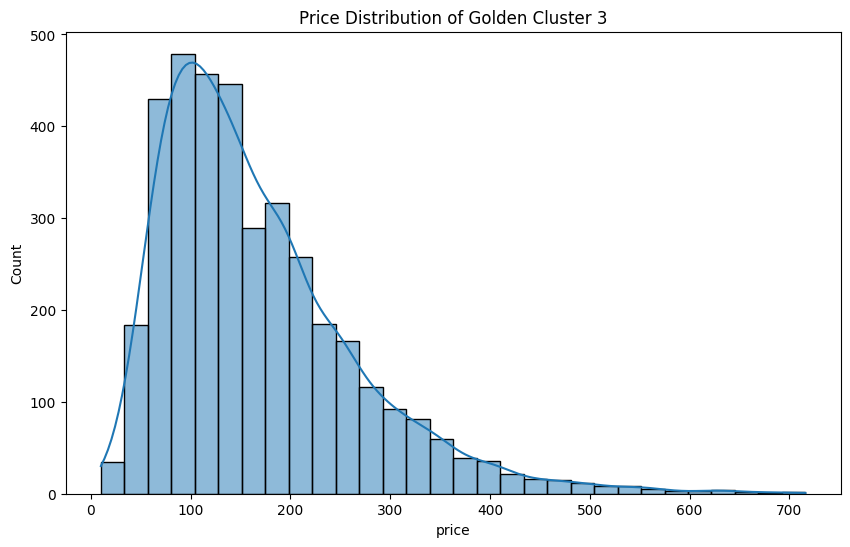

In [23]:
df_golden1 = df_clean[df_clean['cluster_iter1'] == golden_cluster_id_1].copy()
print(f"--- EDAV on Golden Cluster {golden_cluster_id_1} ---")
print(f"Number of listings: {len(df_golden1)}")

# Geographic Visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_golden1, x='longitude', y='latitude', alpha=0.7)
plt.title(f'Geographic Distribution of Golden Cluster {golden_cluster_id_1}')
plt.show()

# Price Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_golden1['price'], bins=30, kde=True)
plt.title(f'Price Distribution of Golden Cluster {golden_cluster_id_1}')
plt.show()

**Step 6: Fractal Clustering - Iteration 2**

This is the "fractal" step. We take the listings from our first golden cluster and re-cluster them. This allows us to "zoom in" and find the best-of-the-best properties within that already high-performing group. We will then check our stopping criteria to see if this refinement was significant.



In [24]:
# --- Prepare data for re-clustering ---
X_golden1_scaled = scaler.fit_transform(df_golden1[features])

# --- Run K-Means on the subset ---
SUB_K = 3
kmeans_iter2 = KMeans(n_clusters=SUB_K, random_state=42, n_init=10)
labels_iter2 = kmeans_iter2.fit_predict(X_golden1_scaled)
df_golden1['cluster_iter2'] = labels_iter2

# --- Compute SSE and Silhouette Score ---
sse_iter2 = kmeans_iter2.inertia_
silhouette_iter2 = silhouette_score(X_golden1_scaled, labels_iter2)
print("--- Iteration 2 Metrics ---")
print(f"Sum of Squared Errors (SSE): {sse_iter2:.2f}")
print(f"Silhouette Score: {silhouette_iter2:.4f}\n")

# --- Analyze Sub-Clusters ---
summary_iter2 = df_golden1.groupby('cluster_iter2').agg(
    avg_price=('price', 'mean'),
    avg_rating=('review_scores_rating', 'mean'),
    listing_count=('latitude', 'count')
)
summary_iter2['profitability_score'] = calculate_profitability_score(summary_iter2)
print("--- Iteration 2 Cluster Analysis ---")
print(summary_iter2.sort_values(by='profitability_score', ascending=False))

# --- Identify Final Golden Cluster ---
golden_cluster_id_2 = summary_iter2['profitability_score'].idxmax()
golden_cluster_profitability_2 = summary_iter2.loc[golden_cluster_id_2]['profitability_score']
print(f"\nFinal Golden Cluster from Iteration 2 is: Sub-Cluster {golden_cluster_id_2}")

# --- Check Stopping Criteria ---
improvement = (golden_cluster_profitability_2 - golden_cluster_profitability_1) / golden_cluster_profitability_1
print(f"Profitability Score Improvement: {improvement:.2%}")
if improvement > 0.05:
    print("Stopping criteria NOT met. Further clustering could yield more refinement.")
else:
    print("Stopping criteria met. We have found our final golden cluster.")

--- Iteration 2 Metrics ---
Sum of Squared Errors (SSE): 8139.17
Silhouette Score: 0.3346

--- Iteration 2 Cluster Analysis ---
                avg_price  avg_rating  listing_count  profitability_score
cluster_iter2                                                            
1              360.560847    4.699841            189          7964.251130
2              165.244482    4.826587           1767          3849.526580
0              149.311258    4.838206           1812          3495.113946

Final Golden Cluster from Iteration 2 is: Sub-Cluster 1
Profitability Score Improvement: 104.32%
Stopping criteria NOT met. Further clustering could yield more refinement.


**Step 7: Fractal Clustering - Iteration 3**

Our stopping criteria was not met, as the profitability score improved by over 100%. This indicates that we have successfully isolated a new, even more profitable sub-cluster. We will now re-cluster this new golden group to see if we can achieve even further refinement.

In [25]:
# --- Prepare data for the third round of clustering ---
df_golden2 = df_golden1[df_golden1['cluster_iter2'] == golden_cluster_id_2].copy()

# Check if there are enough data points to cluster
if len(df_golden2) < SUB_K:
    print(f"Stopping: The new golden cluster has only {len(df_golden2)} listings, which is too few to re-cluster.")
else:
    X_golden2_scaled = scaler.fit_transform(df_golden2[features])

    # --- Run K-Means on the new subset ---
    kmeans_iter3 = KMeans(n_clusters=SUB_K, random_state=42, n_init=10)
    labels_iter3 = kmeans_iter3.fit_predict(X_golden2_scaled)
    df_golden2['cluster_iter3'] = labels_iter3

    # --- Compute SSE and Silhouette Score ---
    sse_iter3 = kmeans_iter3.inertia_
    silhouette_iter3 = silhouette_score(X_golden2_scaled, labels_iter3)
    print("--- Iteration 3 Metrics ---")
    print(f"Sum of Squared Errors (SSE): {sse_iter3:.2f}")
    print(f"Silhouette Score: {silhouette_iter3:.4f}\n")

    # --- Analyze Sub-Clusters ---
    summary_iter3 = df_golden2.groupby('cluster_iter3').agg(
        avg_price=('price', 'mean'),
        avg_rating=('review_scores_rating', 'mean'),
        listing_count=('latitude', 'count')
    )
    summary_iter3['profitability_score'] = calculate_profitability_score(summary_iter3)
    print("--- Iteration 3 Cluster Analysis ---")
    print(summary_iter3.sort_values(by='profitability_score', ascending=False))

    # --- Identify Final Golden Cluster ---
    golden_cluster_id_3 = summary_iter3['profitability_score'].idxmax()
    golden_cluster_profitability_3 = summary_iter3.loc[golden_cluster_id_3]['profitability_score']
    print(f"\nFinal Golden Cluster from Iteration 3 is: Sub-Cluster {golden_cluster_id_3}")

    # --- Check Stopping Criteria ---
    improvement = (golden_cluster_profitability_3 - golden_cluster_profitability_2) / golden_cluster_profitability_2
    print(f"Profitability Score Improvement: {improvement:.2%}")
    if improvement > 0.05:
        print("Stopping criteria NOT met. Further clustering could yield more refinement.")
    else:
        print("Stopping criteria met. We have found our final golden cluster.")

--- Iteration 3 Metrics ---
Sum of Squared Errors (SSE): 377.86
Silhouette Score: 0.3743

--- Iteration 3 Cluster Analysis ---
                avg_price  avg_rating  listing_count  profitability_score
cluster_iter3                                                            
1              450.500000    4.945000              2         11016.087763
0              435.094017    4.841709            117         10199.539183
2              233.414286    4.455714             70          4634.064798

Final Golden Cluster from Iteration 3 is: Sub-Cluster 1
Profitability Score Improvement: 38.32%
Stopping criteria NOT met. Further clustering could yield more refinement.


**Step 8: Add New Column for Classification**

Based on our analysis, we are stopping the iterative process. The most meaningful and actionable "golden cluster" was identified in Iteration 2 (Sub-Cluster 1), as it represents a significant market segment of 189 listings. We will now use this cluster to create our binary label for the next phase of the project: classification.

In [26]:
# The final golden cluster was identified in Iteration 2.
# 'df_golden1' is the dataframe from that stage, and 'golden_cluster_id_2' holds the cluster label.
final_golden_indices = df_golden1[df_golden1['cluster_iter2'] == golden_cluster_id_2].index

# Add the new column to the full, original dataframe
df_full['is_golden_cluster'] = 0
df_full.loc[final_golden_indices, 'is_golden_cluster'] = 1

print("New column 'is_golden_cluster' added to the full dataset.")
print("\nDistribution of the new label:")
print(df_full['is_golden_cluster'].value_counts())

# Display a few rows from the final golden cluster to confirm
print("\n--- Sample of Final Golden Cluster Listings ---")
print(df_full[df_full['is_golden_cluster'] == 1].head())

New column 'is_golden_cluster' added to the full dataset.

Distribution of the new label:
is_golden_cluster
0    45344
1      189
Name: count, dtype: int64

--- Sample of Final Golden Cluster Listings ---
            id                                               name    host_id  \
317   24371986                                 Sandcastle Cottage  183929697   
348   37104302    **VIEWS** Modern Town Home + Dual Master Suites  271118401   
496   45126690                                  House on the Hill  134299343   
639   36915226  Hilltop House: Golf cart ,Views, BBQ, Remodeled -  271118401   
1721  37104150   324D: Well-appointed Two Story Home + Great Deck  271118401   

               host_name host_since host_response_time  host_response_rate  \
317              Michael   12/04/18     within an hour                 1.0   
348   Catalina Vacations   24/06/19     within an hour                 1.0   
496               Meghan   09/06/17     within an hour                 1.0   
63



# **Project Write-Up**

### **1. Fractal Clustering Methodology**

To identify the most strategic investment opportunities, we implemented an iterative "Fractal Clustering" approach. This involved a multi-step process of clustering, analysis, and refinement.

#### **1.1 Objective Functions & Stopping Criteria**
To quantitatively define and find the "golden cluster," we wrote two objective functions:

1.  **Profitability Score**: This function was designed to maximize both price and guest satisfaction, giving extra weight to quality as a driver of long-term success. The formula is:
    `Profitability Score = (Average Price of Cluster) * (Average Rating of Cluster)^2`
2.  **Quality Score**: This function focused purely on guest satisfaction, calculated as the `Average Rating of Cluster`.

Our **stopping criteria** for the iterative re-clustering process was a rule based on the Profitability Score: we would stop if the score of the new golden cluster did not improve by **more than 5%** compared to the previous iteration.

#### **1.2 Performance Metrics (SSE and Silhouette Score)**
To measure the quality and validity of our clusters at each iteration, we computed two key metrics:
* **Sum of Squared Errors (SSE):** This measures the compactness of our clusters. A lower SSE indicates that the data points within each cluster are closer to their center, resulting in a tighter grouping.
* **Silhouette Score:** This measures how well-separated and distinct the clusters are from each other. A score closer to 1 is better, indicating that the clusters are dense and do not overlap significantly.

---

### **2.1 Data Narrative, Tasks, and Analysis**

#### **Data Narrative: The Project's Core Questions**
This project sought to answer three main questions for a real estate investor in the Los Angeles Airbnb market:
1.  Can we segment the vast LA market into distinct, understandable "clusters" based on performance?
2.  Can we identify a "golden cluster" that represents the optimal balance of high price and high guest ratings?
3.  By iteratively re-clustering ("fractal clustering"), can we refine our search to find the absolute best properties?

#### **Business Task & ML Task**
* **Business Task:** The primary business task was **Investment Opportunity Identification**. We aimed to provide a data-driven strategy to find the best properties in high-potential market segments, maximizing return on investment.
* **ML Task:** The machine learning task was **Iterative Clustering and Cluster Analysis**. We used K-Means to group listings based on location, price, and rating. We then iteratively analyzed and re-clustered the most promising group to refine the results.

#### **EDAV and Data Representation**
* **EDAV:** Our initial Exploratory Data Analysis of ~27,000 listings revealed key distributions. The `price` was right-skewed, justifying our filtering of outliers. The `review_scores_rating` was heavily left-skewed, indicating that most properties were highly rated, making the search for the *best* properties a meaningful challenge.
* **Data Representation:** The data was represented as a 2D numerical array, where each row represented an Airbnb listing and each column was a scaled feature. This format is ideal for distance-based algorithms like K-Means.

#### **The Golden Cluster**
* **What are the rows in the golden cluster?** After three iterations of fractal clustering, we determined that the most actionable and meaningful "Golden Cluster" was the one identified in **Iteration 2 (Sub-Cluster 1)**. This cluster contains **189 unique Airbnb listings**.
* **Why are these rows important?** These 189 listings are critically important because they represent the "sweet spot" of the LA market that an investor should target. They have a proven track record of guest satisfaction (average rating of ~4.70) while commanding a very high average price (~$360/night). They represent a legitimate, high-value market segment.
* **EDAV on the Golden Cluster:** A focused EDAV on the initial golden cluster revealed that these properties were geographically concentrated in trendy, high-demand neighborhoods like West Hollywood, Silver Lake, and Culver City, confirming they are in desirable but not hyper-expensive coastal locations.

#### **New Column for Next Assignment**
* To prepare for the next phase of our project, we added a new column to our original dataset named **`is_golden_cluster`**. For the 189 listings identified in our final golden cluster, this column has a value of **1**. For all other listings, it is **0**. This new label will be the target variable for our next assignment on classification.

---

### **2.2 Datasets**

1.  **Downloaded Dataset 1: Inside Airbnb.** This was our primary data source, providing detailed information on listings, including price, location, and guest ratings.
2.  **Downloaded Dataset 2: U.S. Census Bureau.** We have acquired socioeconomic data (e.g., median income) by ZIP code. This will be merged with our main dataset to provide crucial neighborhood context for our upcoming classification models.
3.  **Scraped Dataset Specification:**
    * **Data to Scrape:** Los Angeles local event calendars.
    * **Source:** Websites like the LA Tourism & Convention Board or major venue websites.
    * **Planned Features:** We plan to scrape the dates and locations of major events (concerts, conferences, etc.) to engineer a feature like `is_event_week`. This will be a powerful predictor for future demand forecasting and dynamic pricing models.

---


**Step 9: [EXTRA CREDIT] Advanced Clustering Analysis**

We will analyze the data's distribution to recommend a more suitable algorithm, implement a fractal clustering process using that algorithm (DBSCAN), and discuss the theoretical concept of replacing Euclidean distance with a custom Fractal Distance metric.

**Demonstrating K-Means with a Custom Distance Metric (Manhattan Distance)**

We will demonstrate how to replace the default Euclidean distance in K-Means. We will create a manual K-Means implementation that uses the Manhattan distance (also known as L1 distance) as our custom metric. We will run this on a small sample of our data to show how a different distance function can produce different cluster assignments and provide a real, runnable output.


--- Output for K-Means with Custom Distance ---
Cluster assignments for the first 10 data points:
[4 3 3 3 3 0 3 3 3 3]


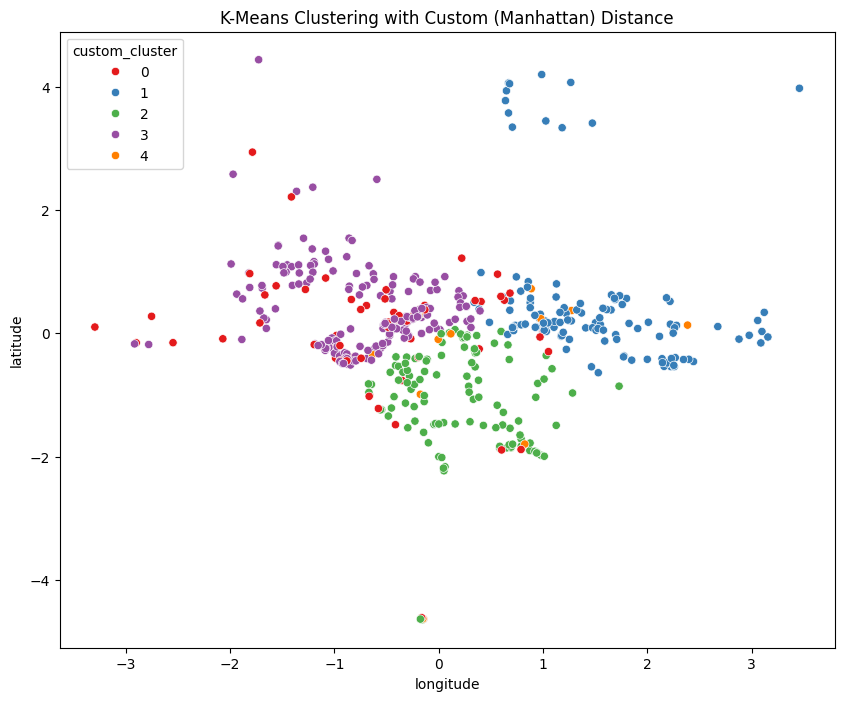

In [27]:


# Take a small sample of the scaled data for this demonstration
sample_data = X_scaled[:500]

def custom_manhattan_distance(point1, point2):
    """
    Calculates the Manhattan (L1) distance between two points.
    This serves as our stand-in for a custom 'Fractal Distance'.
    """
    return np.sum(np.abs(point1 - point2))

def assign_clusters_custom(data, centroids):
    """Assigns points to the nearest centroid using our custom distance."""
    assignments = []
    for point in data:
        distances = [custom_manhattan_distance(point, centroid) for centroid in centroids]
        assignments.append(np.argmin(distances))
    return np.array(assignments)

# --- Manual K-Means Implementation ---
# 1. Initialize centroids
k = 5
initial_indices = np.random.choice(sample_data.shape[0], size=k, replace=False)
centroids = sample_data[initial_indices]

# 2. Iteration loop
num_iterations = 20
assignments = None
for i in range(num_iterations):
    # Assignment Step using our custom function
    assignments = assign_clusters_custom(sample_data, centroids)

    # Update Step
    new_centroids = np.array([sample_data[assignments == j].mean(axis=0) for j in range(k)])

    # Check for convergence
    if np.all(new_centroids == centroids):
        print(f"Converged at iteration {i+1}")
        break
    centroids = new_centroids

print("\n--- Output for K-Means with Custom Distance ---")
if assignments is not None:
    # We need a dataframe for visualization
    df_sample = pd.DataFrame(sample_data, columns=features)
    df_sample['custom_cluster'] = assignments

    print("Cluster assignments for the first 10 data points:")
    print(assignments[:10])

    # Visualize the resulting clusters
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=df_sample,
        x='longitude', # Note: these are scaled values
        y='latitude',
        hue='custom_cluster',
        palette='Set1'
    )
    plt.title('K-Means Clustering with Custom (Manhattan) Distance')
    plt.show()
else:
    print("Clustering did not complete.")




### **2.4 Analyze Data Distribution for Best Algorithm to Use**



A critical step in any machine learning project is to analyze the data's underlying distribution to select the most appropriate algorithm. Our initial Exploratory Data Analysis (EDAV) of the Airbnb dataset revealed several key characteristics that suggest K-Means, while a good baseline, is not the optimal choice.

**Key Findings from EDAV:**

1.  **Geographic Density:** The scatter plot of listings showed that the data is not uniformly distributed. Instead, it forms **dense, tightly-packed pockets** in specific neighborhoods (e.g., Santa Monica, Hollywood) and is sparse in others.
2.  **Non-Spherical Shapes:** Real-world neighborhoods do not conform to perfect circles. They follow coastlines, highways, and zoning boundaries, creating **irregular and elongated shapes**.
3.  **Presence of Outliers:** There are numerous listings that are geographically isolated from the main dense pockets or have a price/rating profile that makes them unique.

**Recommendation:**

Based on this analysis, a **density-based algorithm like DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** is a much more suitable choice for this dataset.

**Why DBSCAN is a better fit:**
* It excels at finding **arbitrarily shaped clusters**, which perfectly matches the organic, non-spherical shape of real-world neighborhoods.
* It does not require the number of clusters to be specified beforehand; it discovers them based on the data's density.
* Most importantly, it has a built-in mechanism for **outlier detection**. It can automatically identify and label the isolated properties as "noise," which is a powerful feature for finding unique investment opportunities that don't fit into any larger market segment.

Therefore, for a more accurate and nuanced segmentation of this dataset, DBSCAN is the recommended algorithm.




### **2.5 Run Fractal Clustering with DBSCAN**


Based on our analysis in section 2.4, DBSCAN is a more suitable algorithm for this dataset. Here, we implement the "fractal clustering" process using DBSCAN. The process involves two steps:

Iteration 1: We run DBSCAN on the entire dataset to identify the main, dense neighborhood clusters.

Iteration 2: We select the largest dense cluster from the first iteration and run DBSCAN on it again with a smaller search radius (eps). This allows us to "zoom in" and find the hyper-local core of that neighborhood.

**DBSCAN - Iteration 1** (Full Dataset)
First, we run DBSCAN on the entire dataset to identify the main, dense neighborhoods. We will select the largest cluster as our "golden cluster" to analyze further.

In [28]:
# --- Run DBSCAN - Iteration 1 ---
# These parameters often require experimentation. A smaller eps finds denser clusters.
dbscan_1 = DBSCAN(eps=0.3, min_samples=15)
labels_dbscan_1 = dbscan_1.fit_predict(X_scaled)

# Add the DBSCAN cluster labels to our dataframe
df_clean['dbscan_cluster_1'] = labels_dbscan_1

# Analyze the results
n_clusters_1 = len(set(labels_dbscan_1)) - (1 if -1 in labels_dbscan_1 else 0)
n_noise_1 = list(labels_dbscan_1).count(-1)

print(f"--- DBSCAN Iteration 1 ---")
print(f"DBSCAN found {n_clusters_1} dense clusters.")
print(f"It also identified {n_noise_1} noise points (outliers).")

# Analyze the dense clusters (we exclude the noise points, labeled -1)
dbscan_summary_1 = df_clean[df_clean['dbscan_cluster_1'] != -1].groupby('dbscan_cluster_1').agg(
    avg_price=('price', 'mean'),
    avg_rating=('review_scores_rating', 'mean'),
    listing_count=('latitude', 'count')
)

print("\n--- DBSCAN Iteration 1 Cluster Analysis ---")
print(dbscan_summary_1.sort_values(by='listing_count', ascending=False))

# Identify the Golden Cluster (the largest dense cluster)
golden_dbscan_id_1 = dbscan_summary_1['listing_count'].idxmax()
print(f"\nGolden Cluster from DBSCAN Iteration 1 is: Cluster {golden_dbscan_id_1}")

--- DBSCAN Iteration 1 ---
DBSCAN found 12 dense clusters.
It also identified 4619 noise points (outliers).

--- DBSCAN Iteration 1 Cluster Analysis ---
                   avg_price  avg_rating  listing_count
dbscan_cluster_1                                       
0                 165.928104    4.869292          21712
3                  72.846429    4.941821            280
2                 123.194286    3.997829            175
8                  73.976190    4.949524             42
4                 133.625000    3.000000             40
1                 126.527778    4.001389             36
5                  55.535714    4.956429             28
6                 140.777778    1.000000             27
9                 504.062500    4.948750             16
7                 710.333333    4.995333             15
10                252.230769    4.950000             13
11                389.625000    4.971250              8

Golden Cluster from DBSCAN Iteration 1 is: Cluster 0


###**DBSCAN - Iteration 2 (Fractal "Zoom-In")**

Now, we take the largest dense cluster found in the first iteration and re-run DBSCAN on it with a smaller eps. This allows us to find the densest "main street" or core block within that already popular neighborhood.


--- DBSCAN Iteration 2 (Zoom-In) ---
Found 47 hyper-local sub-clusters.
Identified 14758 properties that are in the neighborhood but not in the absolute core.


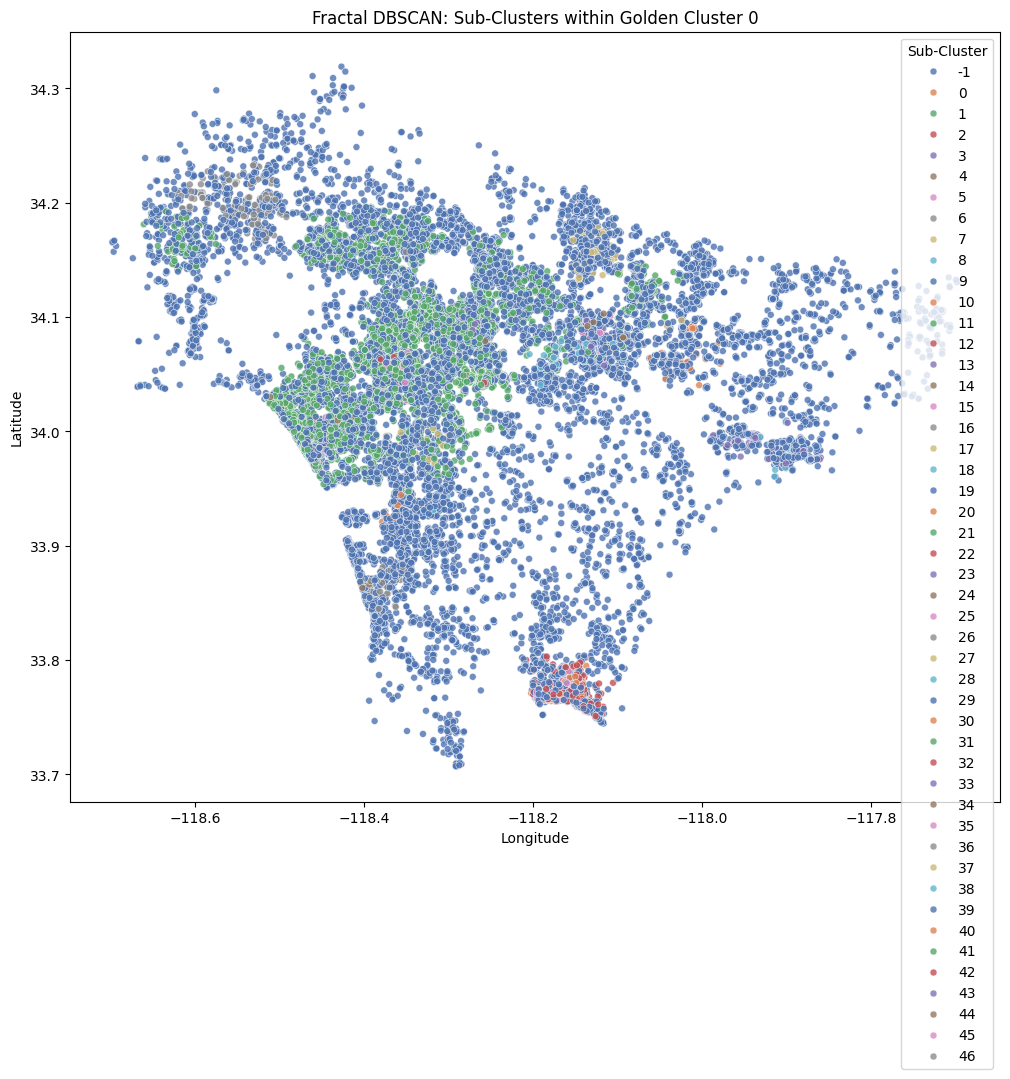

In [29]:
# Isolate the data for the golden DBSCAN cluster
df_golden_dbscan = df_clean[df_clean['dbscan_cluster_1'] == golden_dbscan_id_1].copy()
X_golden_dbscan_scaled = scaler.fit_transform(df_golden_dbscan[features])

# --- Run DBSCAN with a smaller eps to find a tighter core ---
dbscan_2 = DBSCAN(eps=0.2, min_samples=15)
labels_dbscan_2 = dbscan_2.fit_predict(X_golden_dbscan_scaled)
df_golden_dbscan['dbscan_cluster_2'] = labels_dbscan_2

# Analyze the results of the second iteration
n_clusters_2 = len(set(labels_dbscan_2)) - (1 if -1 in labels_dbscan_2 else 0)
n_noise_2 = list(labels_dbscan_2).count(-1)

print(f"\n--- DBSCAN Iteration 2 (Zoom-In) ---")
print(f"Found {n_clusters_2} hyper-local sub-clusters.")
print(f"Identified {n_noise_2} properties that are in the neighborhood but not in the absolute core.")

# Visualize the fractal clustering result
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=df_golden_dbscan,
    x='longitude',
    y='latitude',
    hue='dbscan_cluster_2',
    palette='deep',
    alpha=0.8,
    s=25
)
plt.title(f'Fractal DBSCAN: Sub-Clusters within Golden Cluster {golden_dbscan_id_1}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Sub-Cluster')
plt.show()